In [13]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [39]:
def show_images(imgs, titles=[]):
    """最大3列で画像表示
    """
    n = len(imgs)
    w = 3
    h = n // w + 1
    if titles:
        assert len(titles) == n
    plt.figure(figsize=(w*5,h*5))
    for i, img in enumerate(imgs):
        plt.subplot(h, w, i+1)
        if titles:
            plt.title(titles[i])
        if len(img.shape) == 2:
            plt.imshow(img, cmap="gray") # グレイスケール表示
        else:
            plt.imshow(img)
    plt.show()

## 準備

In [40]:
def bgr_to_rgb(img):
    return img[:, :, ::-1]

def rgb_to_gray(img):
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    return 0.2989 * r + 0.5870 * g + 0.1140 * b

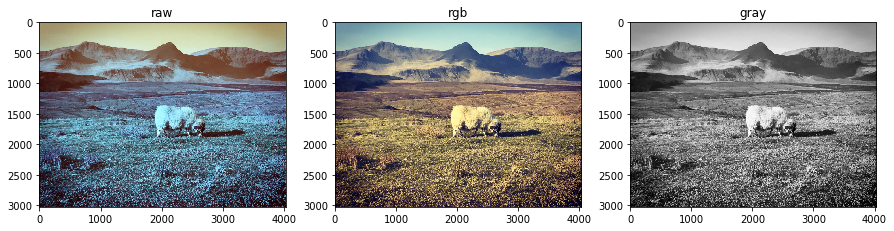

before:  (3022, 4032)
after:  (302, 403)


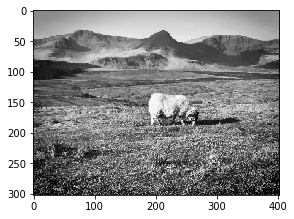

In [48]:
raw_img = cv2.imread("./figures/sample.JPG")
rgb_img = bgr_to_rgb(raw_img)
gray_img = rgb_to_gray(rgb_img)
show_images([raw_img, rgb_img, gray_img], ["raw", "rgb", "gray"])

# resize
print("before: ", gray_img.shape)
size = (gray_img.shape[1]//10, gray_img.shape[0]//10)
gray_img = cv2.resize(gray_img, size)
print("after: ", gray_img.shape)
show_images([gray_img])

## ノイズ付加

In [42]:
def salt_pepper_noise(img, d=0.05):
    img = img.copy()
    h, w = img.shape
    randoms = np.random.random_integers(w*h, size=int(w*h*d))
    for n in randoms:
        i = n // w
        j = n - i*w
        img[i][j] = np.random.choice([0, 255])
    return img

def gaussian_noise(img, d=0.05):
    h, w= img.shape
    mu = 0
    sigma = np.mean(img)*d
    gauss = np.random.normal(mu, sigma, size=(h,w))
    return img+gauss

/Users/arakawariku/.pyenv/versions/miniconda3-3.19.0/envs/ml_env/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 121706 + 1) instead


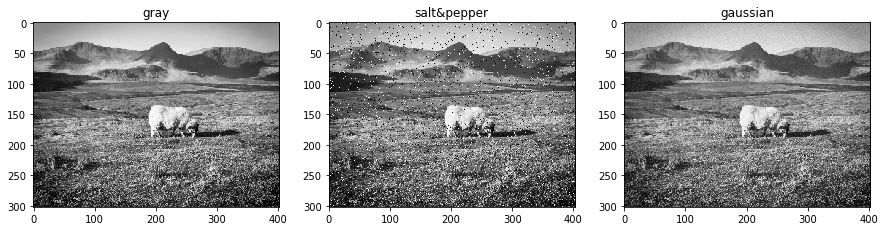

In [43]:
salt_pepper_img = salt_pepper_noise(gray_img)
gaussian_img = gaussian_noise(gray_img)
show_images([gray_img, salt_pepper_img, gaussian_img], ["gray", "salt&pepper", "gaussian"])

## ノイズ除去フィルタ

In [53]:
def convolution(img, kernel):
    """厳密には相関の計算
    ref: https://qiita.com/secang0/items/f3a3ff629988dc660d87
    """
    #部分行列の大きさを計算
    sub_shape = tuple(np.subtract(img.shape, kernel.shape) + 1)
    #関数名が長いのでいったん省略
    strd = np.lib.stride_tricks.as_strided
    #部分行列の行列を作成
    submatrices = strd(img,kernel.shape + sub_shape,img.strides * 2)
    #部分行列とカーネルのアインシュタイン和を計算
    convolved_matrix = np.einsum('ij,ijkl->kl', kernel, submatrices)

    return convolved_matrix

sample_img = np.array([[0,0,0,0,0],
                                  [0,0,0,0,0],
                                  [0,0,1,0,0],
                                  [0,0,0,0,0],
                                  [0,0,0,0,0]])
sample_kernel = np.array([[1,2,3],[4,5,6],[7,8,9]])
convolution(sample_img, sample_kernel)

array([[9, 8, 7],
       [6, 5, 4],
       [3, 2, 1]])

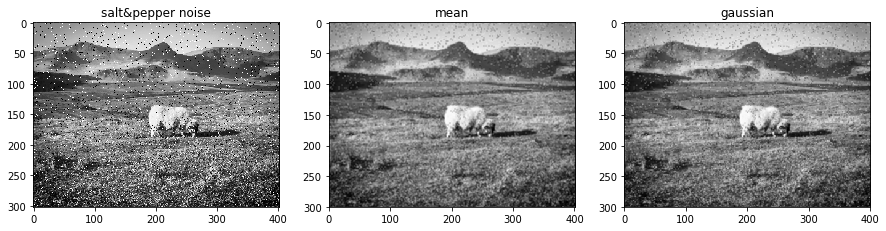

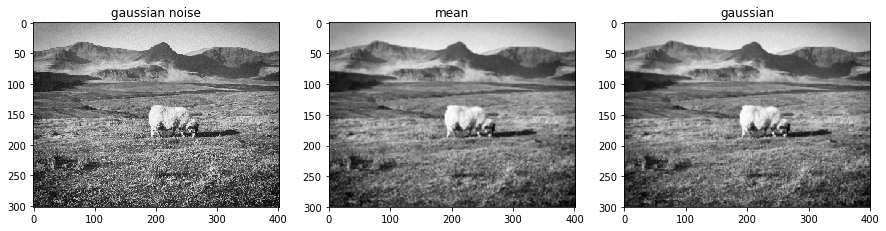

In [54]:
mean_kernel = np.ones((3, 3))/9
gaussian_kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/16
show_images(
                        [salt_pepper_img,
                        convolution(salt_pepper_img, mean_kernel),
                        convolution(salt_pepper_img, gaussian_kernel)],
                        ["salt&pepper noise", "mean", "gaussian"]
             )

show_images(
                        [gaussian_img,
                        convolution(gaussian_img, mean_kernel),
                        convolution(gaussian_img, gaussian_kernel)],
                        ["gaussian noise", "mean", "gaussian"]
             )

## エッジ検出

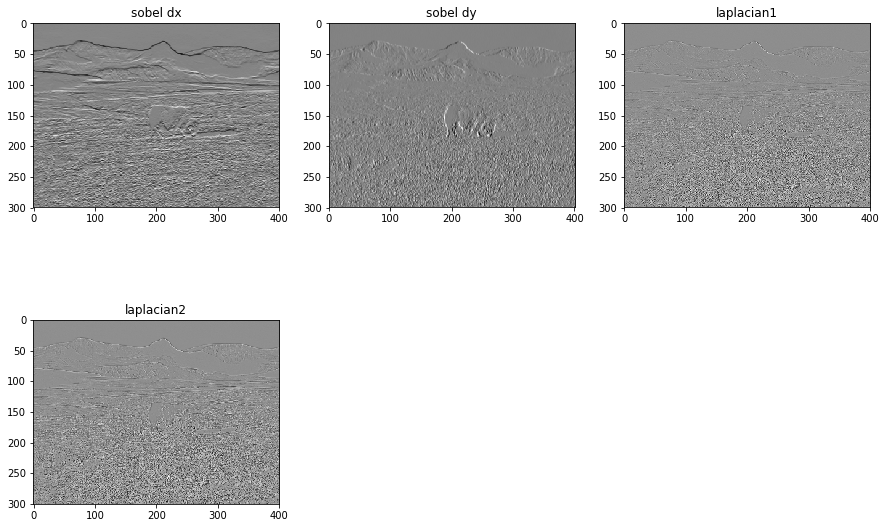

In [57]:
sobel_dx_kernel = np.array([[-1, -2, -1],[0, 0, 0], [1, 2, 1]])
sobel_dy_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
laplacian_kernel1 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
laplacian_kernel2 = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
show_images(
                        [convolution(gray_img, sobel_dx_kernel),
                         convolution(gray_img, sobel_dy_kernel),
                         convolution(gray_img, laplacian_kernel1),
                         convolution(gray_img, laplacian_kernel2)],
                        ["sobel dx", "sobel dy", "laplacian1", "laplacian2"]
)